In [1]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
from skimage.filters import try_all_threshold
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
import skimage.morphology
import skimage.feature
import math
from math import sqrt
from skimage.color import rgb2gray
from skimage import measure
import skan
from skan import csr
from skan import summarize
from skan import draw

Use the following cell to set up a list of the images you want the analysis to run through

In [23]:
image_list = []
names = ['Slide1_section2_60x_zstack', 'Slide10_section4_60x_zstack', 'Slide10_section5_60x_zstack']
#zstacks = 2
conversion = 0.4143 #P14/Adult: 0.4143, P21/P28/P35: 0.5754
for stack in range(1, 5):
    if stack == 1:
        image_list.append(names[0])
    else:
        image_list.append(names[0]+"{}".format(stack))
        
for stack in range(1,8):
    image_list.append(names[1]+"{}".format(stack))
    
for stack in range(1,5):
    image_list.append(names[2]+"{}".format(stack))

In [24]:
image_list

['Slide1_section2_60x_zstack',
 'Slide1_section2_60x_zstack2',
 'Slide1_section2_60x_zstack3',
 'Slide1_section2_60x_zstack4',
 'Slide10_section4_60x_zstack1',
 'Slide10_section4_60x_zstack2',
 'Slide10_section4_60x_zstack3',
 'Slide10_section4_60x_zstack4',
 'Slide10_section4_60x_zstack5',
 'Slide10_section4_60x_zstack6',
 'Slide10_section4_60x_zstack7',
 'Slide10_section5_60x_zstack1',
 'Slide10_section5_60x_zstack2',
 'Slide10_section5_60x_zstack3',
 'Slide10_section5_60x_zstack4']

                        image-id skeleton-id # of branches  \
1     Slide1_section2_60x_zstack           1            31   
2     Slide1_section2_60x_zstack           2            31   
3     Slide1_section2_60x_zstack           3            35   
4     Slide1_section2_60x_zstack           4            21   
5     Slide1_section2_60x_zstack           5            12   
..                           ...         ...           ...   
82  Slide10_section5_60x_zstack4           7            24   
83  Slide10_section5_60x_zstack4           8             9   
84  Slide10_section5_60x_zstack4           9            17   
85  Slide10_section5_60x_zstack4          10            36   
86  Slide10_section5_60x_zstack4          11            17   

    tot. branch length [um]  avg. branch length [um]  
1                197.481593                 6.370374  
2                131.254124                 4.234004  
3                200.253588                 5.721531  
4                 83.555872        

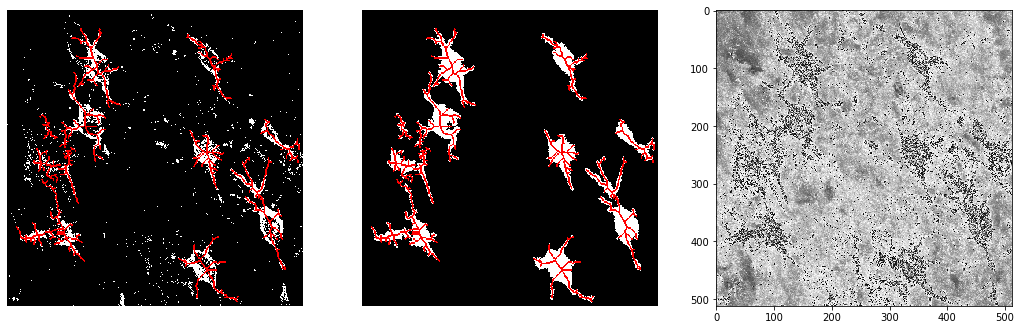

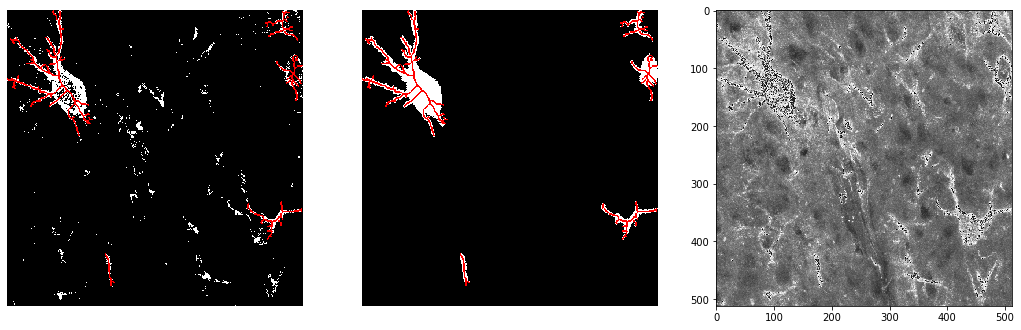

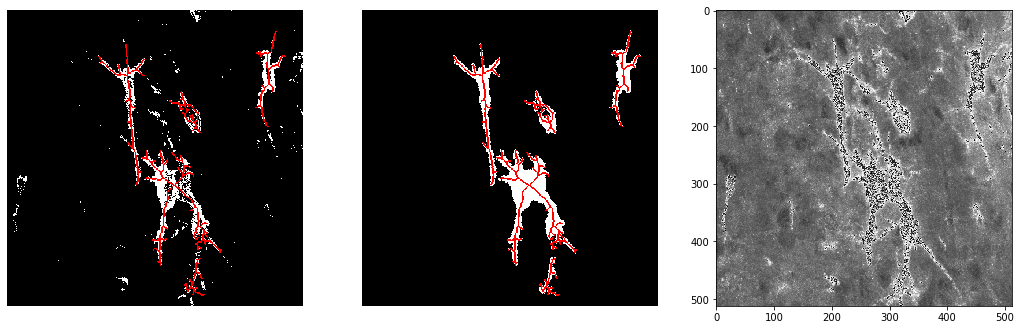

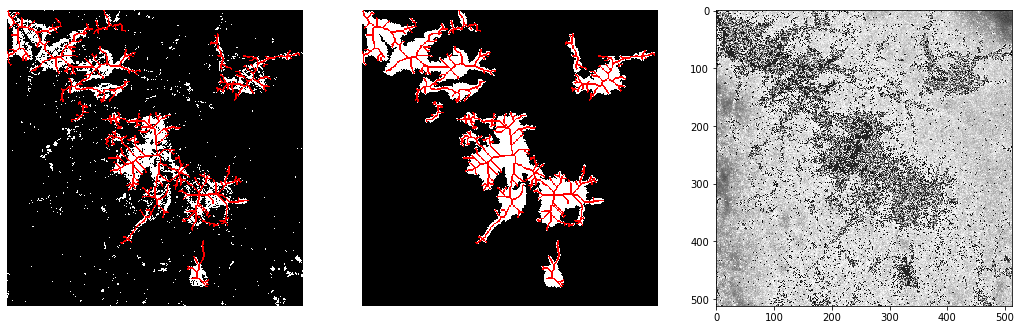

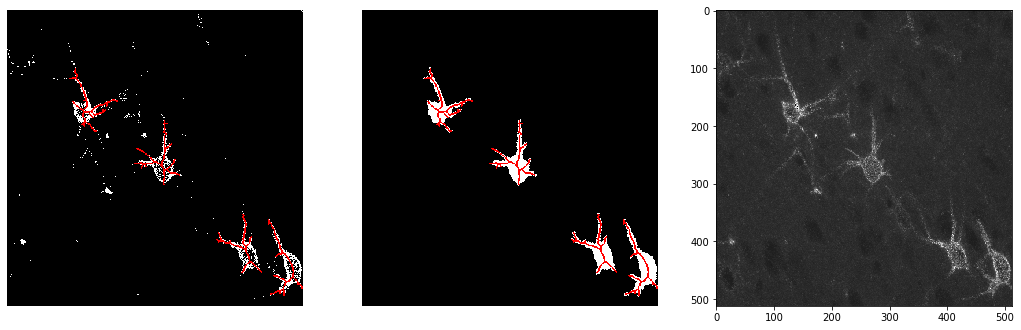

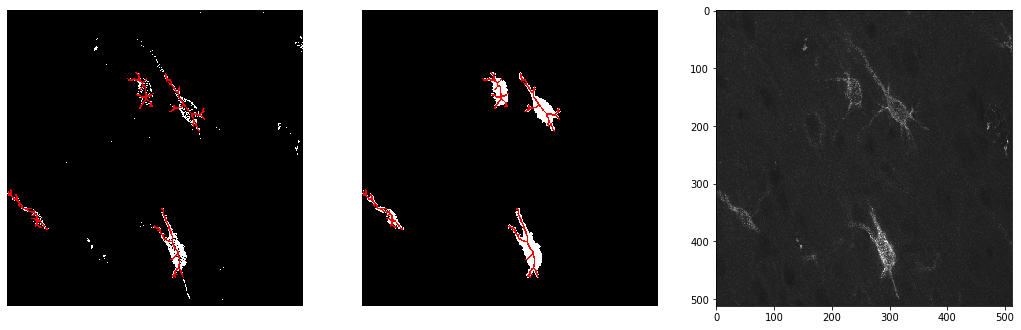

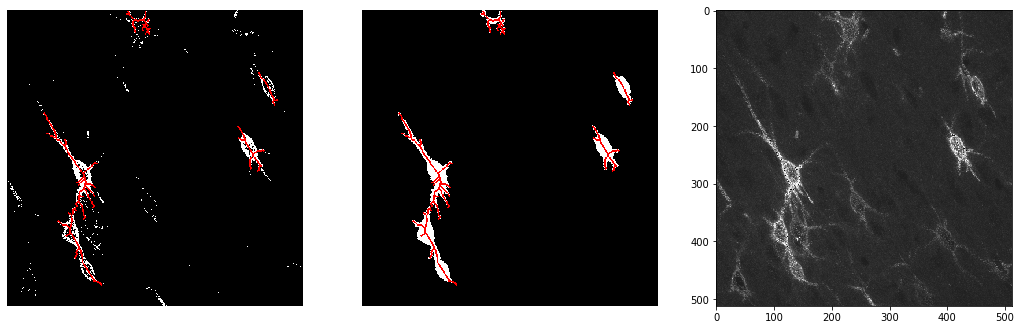

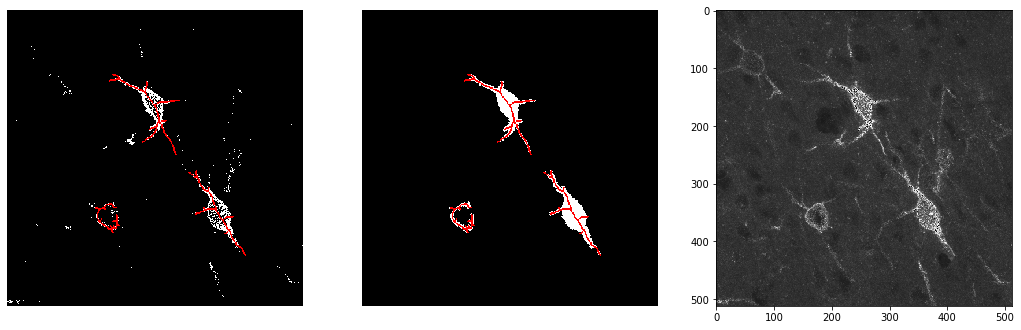

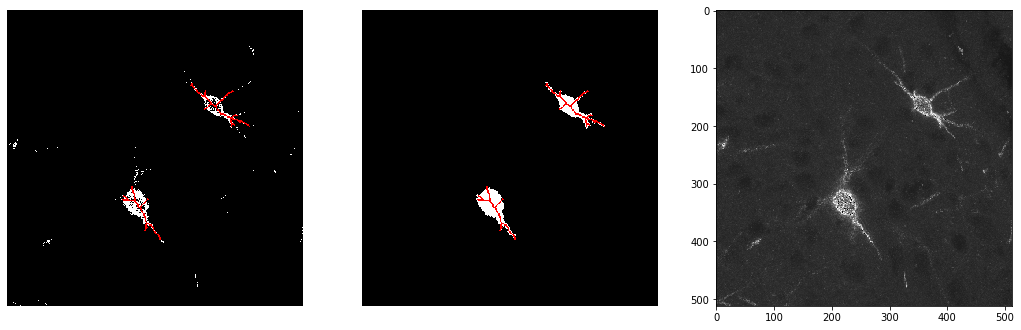

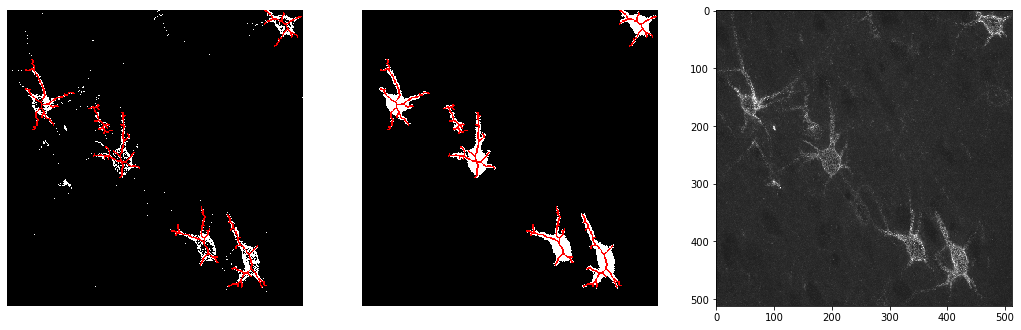

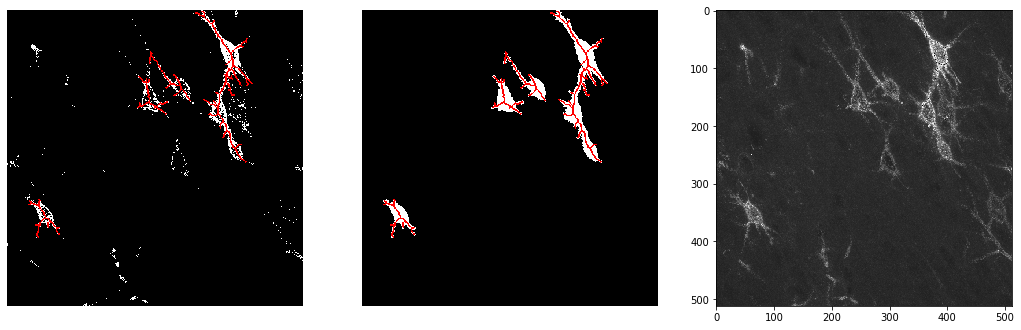

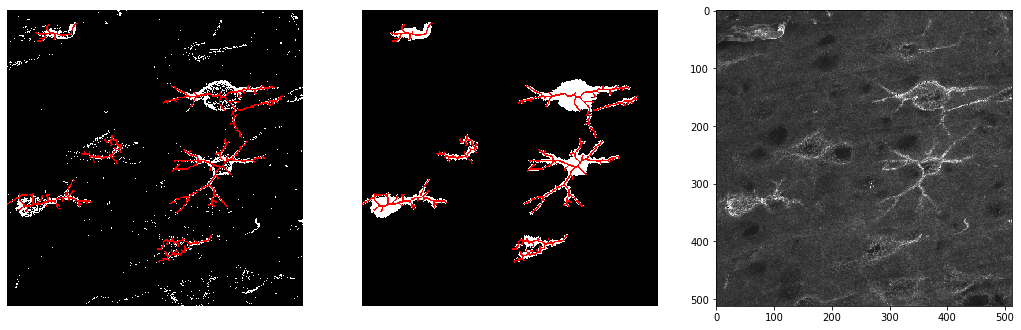

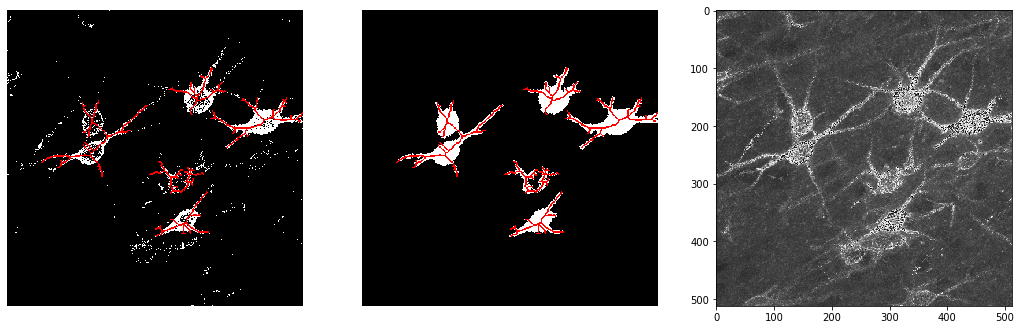

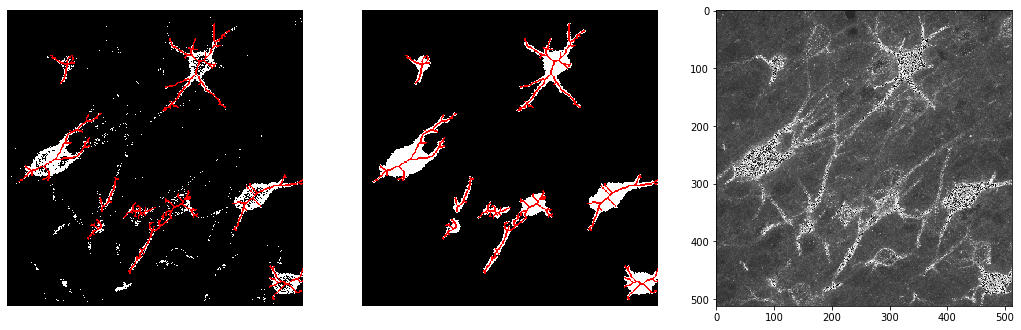

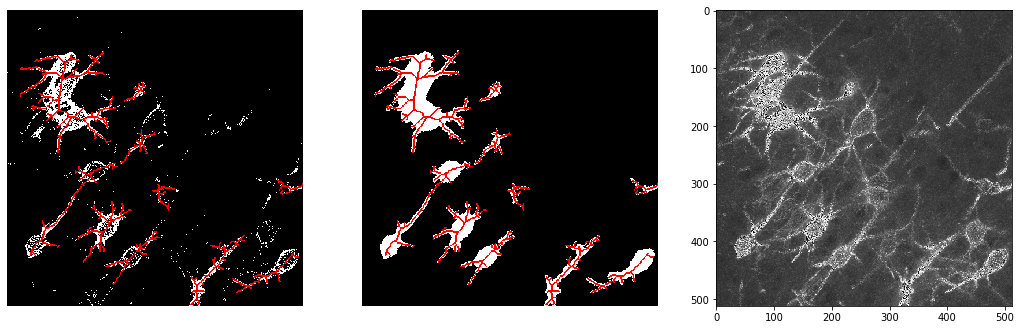

In [25]:
running_total = 0
skel_data = ["image-id","skeleton-id","# of branches","tot. branch length [um]","avg. branch length [um]"]
output_data = pd.DataFrame(columns = skel_data)

for images in image_list:
    img = skimage.io.imread("{}.tif".format(images))
    DAPI = img[0::3]
    PNN = img[1::3]
    PVA = img[2::3]
    DAPI_Max = np.max(DAPI,axis=0)
    PNN_Max = np.max(PNN,axis=0)
    PVA_Max = np.max(PVA,axis=0)
    thresh = skimage.filters.threshold_otsu(PNN_Max)
    PNN_binary = PNN_Max > thresh
    
    PNN_dilation = skimage.morphology.binary_dilation(PNN_binary)
    PNN_filled_holes = ndi.binary_fill_holes(PNN_dilation)
    PNN_clean = skimage.morphology.remove_small_objects(PNN_filled_holes, min_size=400)
    
    skeleton = skimage.morphology.skeletonize(PNN_clean)
    partial_skel = skimage.morphology.thin(PNN_clean, max_iter=5)
    
    clean_skeleton = skimage.morphology.remove_small_objects(skeleton, min_size = 400)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 18))
    ax = axes.ravel()
    #ax[0] = plt.imshow(1-PNN_MaxIP*50, cmap='Greys')
    draw.overlay_skeleton_2d(PNN_binary, skeleton, dilate=1, axes=ax[0])
    draw.overlay_skeleton_2d(PNN_clean, skeleton, dilate=1, axes=ax[1])
    ax[2] = plt.imshow(1-PNN_Max*50, cmap='Greys')
    
    branch_data = csr.summarise(skeleton)
    
    num_skel = max(branch_data["skeleton-id"])
    tot_branch = len(branch_data)
    image_id = images
    for skels in range(1,num_skel+1):
        num_branch = 0
        tot_length = 0 
        for branch in range(0,tot_branch):
            if branch_data["skeleton-id"][branch] == skels:
                num_branch = num_branch+1
                tot_length = tot_length + branch_data["branch-distance"][branch]
        avg_length = tot_length/num_branch
        running_total = running_total+1
        output_data.loc[running_total] = [image_id, skels, num_branch, tot_length*conversion, avg_length*conversion]

print(output_data)
output_data.to_csv("Adult.csv",index = False, header = True)

In [ ]:
img = skimage.io.imread('slide_9_slice_2_60x_z_stack_2.tif')
print(img.shape)
print(img.dtype)
DAPI = img[0::3]
PNN = img[1::3]
PVA = img[2::3]

DAPI_MaxIP = np.max(DAPI,axis=0)
PNN_MaxIP = np.max(PNN,axis=0)
PVA_MaxIP = np.max(PVA,axis=0)

fig, ax = plt.subplots(3,2, figsize=(10, 12))
print(ax)

ax[0,0] = plt.subplot(1, 2, 1)
ax[0,1] = plt.subplot(1, 2, 2)
ax[1,0] = plt.subplot(2, 2, 1)
ax[1,1] = plt.subplot(2, 2, 2)
ax[2,0] = plt.subplot(3, 2, 1)
ax[2,1] = plt.subplot(3, 2, 2)


ax[0,0].imshow(DAPI_MaxIP, cmap=plt.cm.gray)
ax[0,0].set_title('DAPI')
ax[0,0].axis('off')

ax[0,1].hist(DAPI_MaxIP.ravel(), bins=256)
ax[0,1].set_title('DAPI Histogram')

ax[1,0].imshow(PNN_MaxIP, cmap=plt.cm.gray)
ax[1,0].set_title('PNN')
ax[1,0].axis('off')

ax[1,1].hist(PNN_MaxIP.ravel(), bins=256)
ax[1,1].set_title('PNN Histogram')

ax[2,0].imshow(PVA_MaxIP, cmap=plt.cm.gray)
ax[2,0].set_title('PVA Interneurons')
ax[2,0].axis('off')

ax[2,1].hist(PVA_MaxIP.ravel(), bins=256)
ax[2,1].set_title('PVA Histogram')

plt.show()


#DAPIplot = plt.imshow(1-DAPI_MaxIP, cmap='Greys')
#plt.show()
#plt.hist(DAPI_MaxIP.ravel(), bins=256)
#plt.ylim(0, 30000)
#plt.xlim(0, 3000)
#plt.show()
#PNNplot = plt.imshow(1-PNN_MaxIP, cmap='Greys')
#plt.show()
#plt.hist(PNN_MaxIP.ravel(), bins=256)
#plt.ylim(0, 30000)
#plt.xlim(0, 3000)
#plt.show()
#PVAplot = plt.imshow(1-PVA_MaxIP, cmap='Greys')
#plt.show()

In [ ]:
DAPI = img[0::3]
PNN = img[1::3]
PVA = img[2::3]

DAPI_MaxIP = np.max(DAPI,axis=0)
PNN_MaxIP = np.max(PNN,axis=0)
PVA_MaxIP = np.max(PVA,axis=0)


DAPIplot = plt.imshow(1-DAPI_MaxIP, cmap='Greys')
plt.show()
plt.hist(DAPI_MaxIP.ravel(), bins=256)
plt.ylim(0, 30000)
plt.xlim(0, 3000)
plt.show()
PNNplot = plt.imshow(1-PNN_MaxIP, cmap='Greys')
plt.show()
plt.hist(PNN_MaxIP.ravel(), bins=256)
plt.ylim(0, 30000)
plt.xlim(0, 3000)
plt.show()
PVAplot = plt.imshow(1-PVA_MaxIP, cmap='Greys')
plt.show()

In [ ]:
try_all_threshold(PNN_MaxIP, figsize=(20,18))

In [ ]:
thresh = skimage.filters.threshold_otsu(PNN_MaxIP)
PNN_binary = PNN_MaxIP > thresh

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(PNN_MaxIP, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(PNN_MaxIP.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(PNN_binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [ ]:
PNN_dilation = skimage.morphology.binary_dilation(PNN_binary)
PNN_filled_holes = ndi.binary_fill_holes(PNN_dilation)
PNN_clean = skimage.morphology.remove_small_objects(PNN_filled_holes, min_size=400)


fig, axes = plt.subplots(ncols=4, figsize=(16, 8))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3)
ax[3] = plt.subplot(1, 4, 4)
ax[0].imshow(PNN_binary, cmap=plt.cm.gray)
ax[1].imshow(PNN_dilation, cmap=plt.cm.gray)
ax[2].imshow(PNN_filled_holes, cmap=plt.cm.gray)
ax[3].imshow(PNN_clean, cmap=plt.cm.gray)
plt.show()

In [ ]:
skeleton = skimage.morphology.skeletonize(PNN_clean)
partial_skel = skimage.morphology.thin(PNN_clean, max_iter=5)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(PNN_clean, cmap=plt.cm.gray)
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeleton', fontsize=20)

ax[2].imshow(partial_skel, cmap=plt.cm.gray)
ax[2].set_title('partial', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
from skan import draw

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 18))
ax = axes.ravel()
#ax[0] = plt.imshow(1-PNN_MaxIP*50, cmap='Greys')
draw.overlay_skeleton_2d(PNN_binary, skeleton, dilate=1, axes=ax[0])
draw.overlay_skeleton_2d(PNN_clean, skeleton, dilate=1, axes=ax[1])
ax[2] = plt.imshow(1-PNN_MaxIP*50, cmap='Greys')

In [ ]:
from skan import csr
from skan import summarize

branch_data = csr.summarise(skeleton)
print(branch_data.shape)
branch_data

## The goal here is to write a script that will quantify the number of branches, total branch length, and average branch length for each skeleton in the dataframe

In [ ]:
print(branch_data["skeleton-id"].max())
print(branch_data['branch-type'].max(), ",", branch_data['branch-type'].min())
print(len((branch_data)))
print(branch_data['branch-distance'][230])

In [ ]:
skel_data = ["skeleton-id", "# of branches", "total branch length", 'avg branch length']
output_data = pd.DataFrame(columns = skel_data)

num_skel = max(branch_data['skeleton-id'])
tot_branch = len(branch_data)

for skels in range(1, num_skel+1):
    num_branch = 0
    tot_length = 0
    for branch in range(0, tot_branch):
        if branch_data['skeleton-id'][branch] == skels:
            num_branch = num_branch + 1
            tot_length = tot_length + branch_data['branch-distance'][branch]
    avg_length = tot_length/num_branch
    output_data.loc[skels] = [skels, num_branch, tot_length, avg_length]

In [ ]:
output_data

In [ ]:
output_data.plot(x='# of branches', y='total branch length', style='o')
output_data.plot(x='# of branches', y='avg branch length', style='rx')

In [ ]:
print(PNN_clean[0:5])
print(DAPI_MaxIP[0:5])
print(len(PNN_clean))

In [ ]:
filtered_DAPI = np.zeros(int(len(DAPI_MaxIP)),int(len(DAPI_MaxIP))
for ypixel in range(0,len(PNN_clean)):
    for xpixel in range(0,len(PNN_clean)):
        if PNN_clean[ypixel,xpixel] == True:
            filtered_DAPI[ypixel,xpixel] = DAPI_MaxIP[ypixel,xpixel]
        else:
            filtered_DAPI[ypixel,xpixel] = 0


In [ ]:

DAPIplot = plt.imshow(1-DAPI_MaxIP, cmap='Greys')
plt.show()